# Sparkify 项目 Workspace

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .appName('spark_project').getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

user_log = spark.read.json('medium-sparkify-event-data.json')

# 加载和清洗数据
加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, desc, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql import Window

import datetime
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [4]:
# check the frame of the data
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# check the amount of the data
total_row = user_log.count()
print(f'The total number of data is {total_row}')

The total number of data is 543705


In [6]:
# check the information
user_log.describe(['artist','auth','firstName','gender','itemInSession','lastName','length']).show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+
|  count|           432877|    543705|   528005|528005|            543705|  528005|            432877|
|   mean|527.5289537712895|      null|     null|  null|107.30629109535502|    null|248.66459278007585|
| stddev|966.1072451772756|      null|     null|  null|116.72350849188119|    null| 98.41266955052022|
|    min|              !!!| Cancelled|  Aaliyah|     F|                 0|  Abbott|           0.78322|
|    max|ÃÂlafur Arnalds|Logged Out|   Zyonna|     M|              1005|  Wright|        3024.66567|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+



- The `artist` can be null since it depends on whether the user is in the song-played page
- The number of null value of `firstName`, `lastName` and `gender` is the same
- `auth` and `itemInSession` no null value

In [7]:
user_log.describe(['level','location','method','page','registration']).show()

+-------+------+----------------+------+-------+--------------------+
|summary| level|        location|method|   page|        registration|
+-------+------+----------------+------+-------+--------------------+
|  count|543705|          528005|543705| 543705|              528005|
|   mean|  null|            null|  null|   null|1.535523414863871...|
| stddev|  null|            null|  null|   null|3.0787254929958086E9|
|    min|  free|       Akron, OH|   GET|  About|       1509854193000|
|    max|  paid|York-Hanover, PA|   PUT|Upgrade|       1543073874000|
+-------+------+----------------+------+-------+--------------------+



- `level`, `method` and `page` no null value
- number of null value of `location` and `registration` is the same as `firstName`, `lastName`, `gender` (these are all user info)

In [9]:
user_log.describe(['sessionID','song','status','ts','userAgent','userId']).show()

+-------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|         sessionID|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            543705|              432877|            543705|              543705|              528005|            543705|
|   mean|2040.8143533717732|            Infinity|210.01829116892432|1.540964541209800...|                null| 60268.42669103512|
| stddev| 1434.338931078271|                 NaN|31.471919021567537|1.4820571449105084E9|                null|109898.82324176628|
|    min|                 1|ÃÂg ÃÂtti Gr...|               200|       1538352011000|"Mozilla/5.0 (Mac...|                  |
|    max|              4808|ÃÂ¾etta Gerist Ã...|               404|       1543622466000|M

- `sessionID`, `userId`, `status`, `ts` no null value
- number of `song` is the same as `artist`
- `userAgent` is part of user info

In [10]:
# No null value in userId and sessionID, explore more
user_log.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [8]:
# drop the ""
user_log_clean = user_log.filter(user_log['userId'] != "")
print(f'Now the number of data after cleansing is {user_log_clean.count()}')

Now the number of data after cleansing is 528005


In [9]:
# deal with the ts
# turn ts into year, month, day and hour
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).year)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).month)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).day)
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).hour)

# add two new columns datetime and hour
user_log_clean = user_log_clean.withColumn('year', get_year(user_log_clean.ts))
user_log_clean = user_log_clean.withColumn('month', get_month(user_log_clean.ts))
user_log_clean = user_log_clean.withColumn('day', get_day(user_log_clean.ts))
user_log_clean = user_log_clean.withColumn('hour', get_hour(user_log_clean.ts))

user_log_clean.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', year='2018', month='10', day='1', hour='8')

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

## 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

## 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

## 提问
- `Cancellation Confirmation`事件中，有多少是付费客户，多少是免费客户，由付费转为免费，由免费转为付费
- `Cancellation Confirmation`事件中的gender, location, hour, song, artist
- 每个用户总共听了多少首歌
- downgrade后，哪些user选择了cancel
- upgrade后，哪些user选择了cancel
- user对每个页面的使用频率
- user Session次数
- user 注册了多久

In [10]:
#  add churn label: True or False
add_churn_label = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())
user_log_clean = user_log_clean.withColumn('churn', add_churn_label('page'))

In [11]:
# mark the user who downgrade or upgrade
# mark downgrade as 1, upgrade as 2
grade_flag = udf(lambda x: 1 if x=='Submit Downgrade' else 2 if x=='Submit Upgrade' else 0, IntegerType())
# add new columns downgraded, upgraded
user_log_clean = user_log_clean.withColumn('graded', grade_flag('page'))
#user_log_copy.select(["userId", "firstname", "ts", "page", "level", "graded"]).where(user_log_copy.userId == "162").sort("ts").collect()
windowval = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, 0)
user_log_clean = user_log_clean.withColumn("phase", Fsum('graded').over(windowval))
user_log_clean.select(["userId", "firstname", "ts", "page", "level", "graded","phase"])\
             .where(user_log_clean.userId == "162").sort(user_log_clean.ts.desc()).take(5)

[Row(userId='162', firstname='Lakyla', ts=1542055421000, page='Cancel', level='paid', graded=0, phase=2),
 Row(userId='162', firstname='Lakyla', ts=1542055421000, page='Cancellation Confirmation', level='paid', graded=0, phase=2),
 Row(userId='162', firstname='Lakyla', ts=1542055420000, page='Roll Advert', level='paid', graded=0, phase=2),
 Row(userId='162', firstname='Lakyla', ts=1542054649000, page='NextSong', level='paid', graded=0, phase=2),
 Row(userId='162', firstname='Lakyla', ts=1542054358000, page='NextSong', level='paid', graded=0, phase=2)]

In [12]:
user_log_clean.select('userId').drop_duplicates(['userId']).count()

448

In [13]:
# use coalesce to make sure no shuffle!!!
user_log_label = user_log_clean.select('userId','gender','location','level','ts','page','phase','churn')\
                               .sort(user_log_clean.userId, user_log_clean.ts.desc(), user_log_clean.page.desc())\
                               .coalesce(1).drop_duplicates(['userId']).sort('userId')
print(f'The number of users marked as churn is {user_log_label.filter(user_log_label.churn==1).count()}')
#user_log_label.write.save(out_path, format='csv', header=True)
#user_log_label = spark.read.csv(out_path, header=True)
#user_log_label.count()

The number of users marked as churn is 99


some users went through both `downgraded` and `upgraded` (Phase>=3)

In [20]:
# see the behavior of user 100011 (phase=8)
user_log_clean.select('userId','level','graded','phase','page')\
.where((user_log_clean.userId=='100011')&((user_log_clean.page=='Submit Downgrade')|(user_log_clean.page=='Submit Upgrade')))\
.sort(user_log_clean.ts.desc()).collect()

[Row(userId='100011', level='free', graded=2, phase=8, page='Submit Upgrade'),
 Row(userId='100011', level='paid', graded=1, phase=6, page='Submit Downgrade'),
 Row(userId='100011', level='free', graded=2, phase=5, page='Submit Upgrade'),
 Row(userId='100011', level='paid', graded=1, phase=3, page='Submit Downgrade'),
 Row(userId='100011', level='free', graded=2, phase=2, page='Submit Upgrade')]

Text(0, 0.5, 'count')

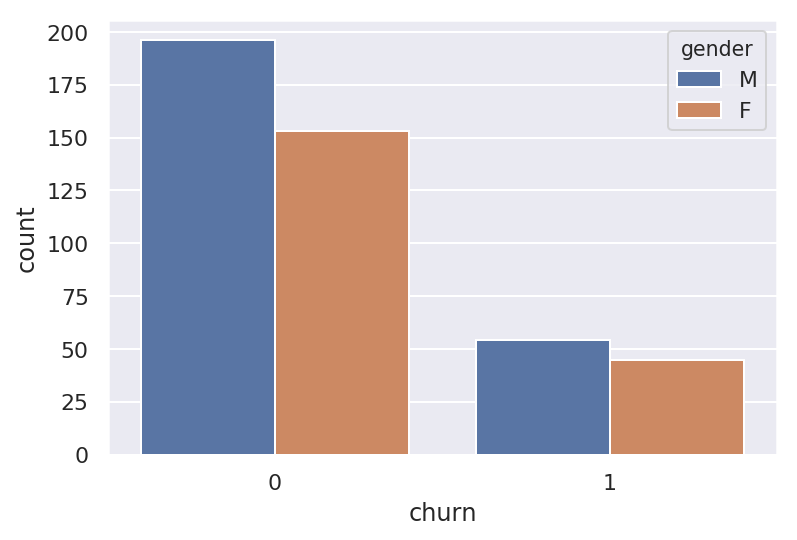

In [23]:
# check male, female
gender_df = user_log_label.select('gender','churn').groupby('gender','churn').count().toPandas()
sns.barplot(x='churn',y='count',hue='gender',data=gender_df)
plt.xlabel('churn')
plt.ylabel('count')

Text(0, 0.5, 'count')

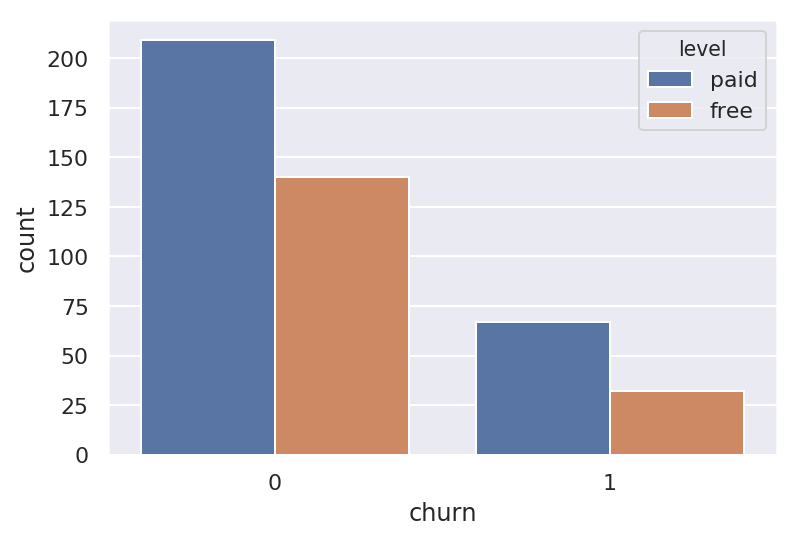

In [19]:
# check level
level_df = user_log_label.select('level','churn').groupby('level','churn').count().toPandas()
sns.barplot(x='churn',y='count',hue='level',data=level_df)
plt.xlabel('churn')
plt.ylabel('count')

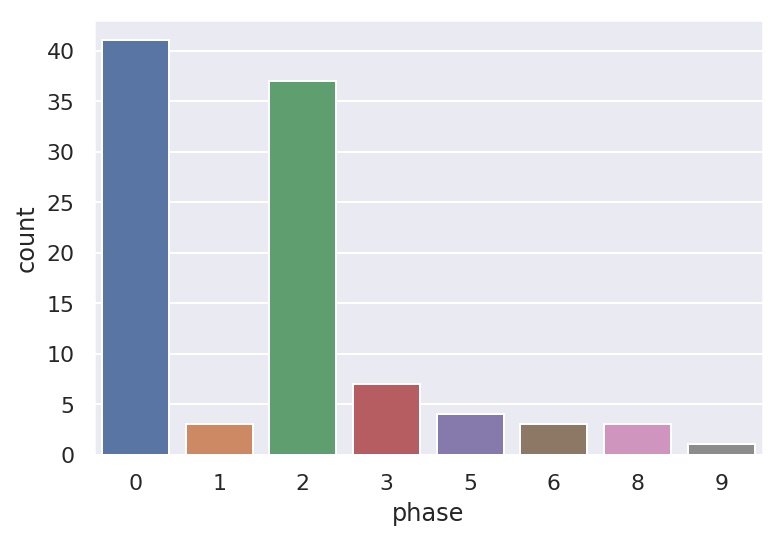

In [42]:
# phase and churn
phase_df = user_log_label.filter(user_log_label.churn==1).select('phase').groupby('phase').count().toPandas()
sns.barplot(x='phase',y='count',data=phase_df)

(-1, 6541.6)

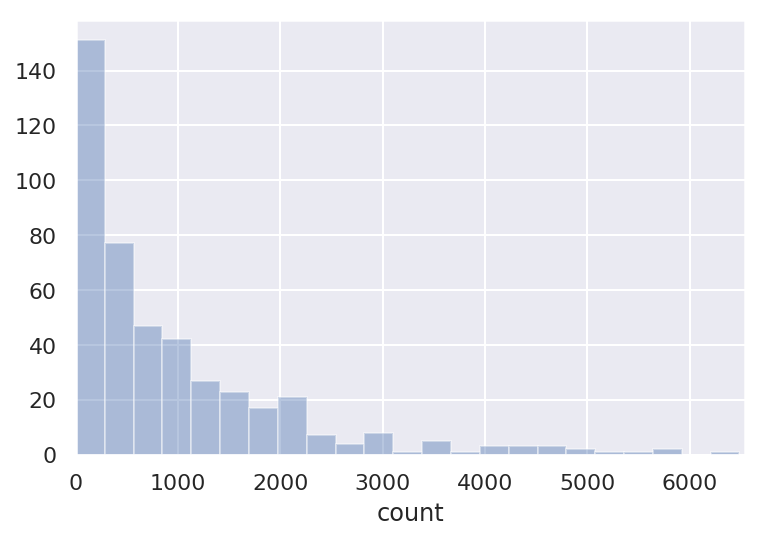

In [45]:
# number of songs each user listen
num_songs_df = user_log_clean.select('userId').where(user_log_clean.page=='NextSong').groupby('userId').count().toPandas()
sns.distplot(num_songs_df['count'], kde=False)
plt.xlim(-1, 0.8*max(num_songs_df['count']))

In [9]:
# join number of songs with user_log_label
user_num_songs = user_log_clean.select('userId').where(user_log_clean.page=='NextSong')\
                               .groupby('userId').count().withColumnRenamed('count','songs_listened').withColumnRenamed('userId','userIdTemp')
user_log_label = user_log_label.join(user_num_songs, user_log_label.userId==user_num_songs.userIdTemp, 'left_outer').drop('userIdTemp')
user_log_label = user_log_label.drop('song_userId')
user_log_label.show()

+------+------+--------------------+-----+-------------+--------------------+-----+-----+--------------+
|userId|gender|            location|level|           ts|                page|phase|churn|songs_listened|
+------+------+--------------------+-----+-------------+--------------------+-----+-----+--------------+
|100010|     F|Bridgeport-Stamfo...| free|1539254318000|Cancellation Conf...|    0|    1|            96|
|200002|     M|Chicago-Napervill...| paid|1540877026000|Cancellation Conf...|    2|    1|           310|
|   296|     F|Allentown-Bethleh...| paid|1539187234000|Cancellation Conf...|    2|    1|           112|
|   125|     M|  Corpus Christi, TX| free|1542265610000|     Add to Playlist|    0|    0|            62|
|   124|     F|Vineland-Bridgeto...| paid|1541948983000|Cancellation Conf...|    0|    1|          1826|
|    51|     M|Lexington-Fayette...| paid|1539709266000|Cancellation Conf...|    0|    1|           266|
|     7|     M|Seattle-Tacoma-Be...| free|1543409350000

(-1, 2000)

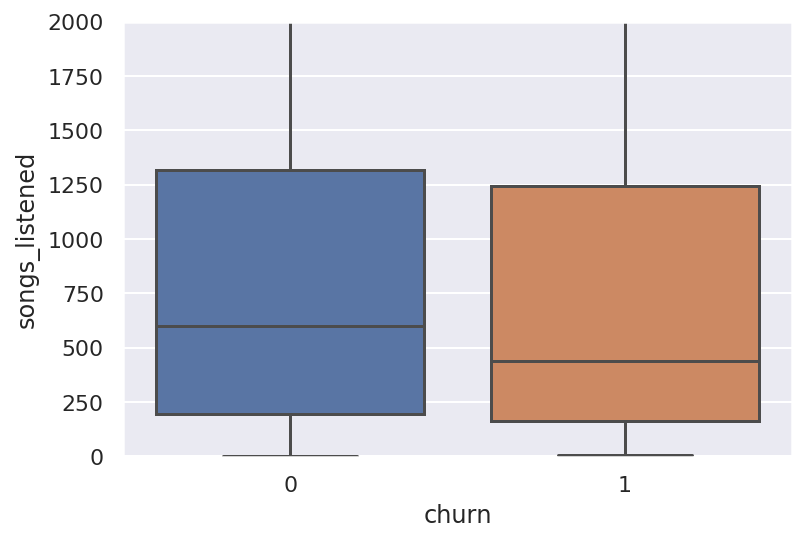

In [62]:
# number of songs users who marked as churn listen
songs_df = user_log_label.select('songs_listened','churn').toPandas()
sns.boxplot(x='churn',y='songs_listened',data=songs_df)
plt.ylim(-1,2000);

In [11]:
### thumbs up or down
user_thumbs_down = user_log_clean.select('userId').where(user_log_clean.page=='Thumbs Down')\
                                 .groupby('userId').count().withColumnRenamed('count', 'num_thumbs_down')
user_thumbs_up = user_log_clean.select('userId').where(user_log_clean.page=='Thumbs Up')\
                                 .groupby('userId').count().withColumnRenamed('count', 'num_thumbs_up')
#assert user_thumbs_down.count()==user_thumbs_up.count()==user_log_label.count()
user_log_label = user_log_label.join(user_thumbs_down, user_log_label.userId==user_thumbs_down.userId, 'outer').drop(user_thumbs_down.userId)
user_log_label = user_log_label.join(user_thumbs_up, user_log_label.userId==user_thumbs_up.userId, 'outer').drop(user_thumbs_up.userId)
user_log_label = user_log_label.fillna(0, subset=['num_thumbs_down','num_thumbs_up'])
user_log_label.show()

+------+--------------------+-----+-------------+--------------------+-----+-----+--------------+------+---------------+-------------+
|gender|            location|level|           ts|                page|phase|churn|songs_listened|userId|num_thumbs_down|num_thumbs_up|
+------+--------------------+-----+-------------+--------------------+-----+-----+--------------+------+---------------+-------------+
|     F|Bridgeport-Stamfo...| free|1539254318000|Cancellation Conf...|    0|    1|            96|100010|              3|            4|
|     M|Chicago-Napervill...| paid|1540877026000|Cancellation Conf...|    2|    1|           310|200002|              5|           15|
|  null|                null| null|         null|                null| null| null|          null|  null|              0|            8|
|     M|  Corpus Christi, TX| free|1542265610000|     Add to Playlist|    0|    0|            62|   125|              1|            3|
|     F|Vineland-Bridgeto...| paid|1541948983000|Cancel

In [34]:
# count thumbs
thumbs_df = user_log_label.select('churn','num_thumbs_down','num_thumbs_up').groupby('num_thumbs_down','churn').sum().toPandas()
thumbs_df

,churn,sum(churn),sum(num_thumbs_down),sum(num_thumbs_up)
0,1,99,1156,4300
1,0,0,3755,19526


In [37]:
# session次数
user_log_clean.select('userId','sessionID').groupby('userId').count().show()

+------+-----+
|userId|count|
+------+-----+
|100010|  137|
|200002|  395|
|   296|  152|
|   125|   84|
|    51|  328|
|   124| 2156|
|     7|  600|
|200037|  155|
|   205| 1244|
|   169|  149|
|   272|  131|
|    54|  624|
|   282| 3191|
|   232| 2325|
|   234| 2021|
|    15| 2173|
|   155|  172|
|200043|  808|
|   154|  126|
|   132|  144|
+------+-----+
only showing top 20 rows



In [12]:
# 平均会话时长
user_sessionTime = user_log_clean.groupby('userId','sessionID').agg(((F.max(user_log_clean.ts)-F.min(user_log_clean.ts))/(1000*60))
                                                 .alias('sessionTime')).sort('userId')
user_sessionTime_stat = user_sessionTime.groupby('userId').agg(avg(user_sessionTime.sessionTime).alias('AvgSessionTime'),
                                                               F.max(user_sessionTime.sessionTime).alias('MaxSessionTime'),
                                                               F.min(user_sessionTime.sessionTime).alias('MinSessionTime')).sort('userId')
user_sessionTime_stat.show()

+------+------------------+------------------+--------------------+
|userId|    AvgSessionTime|    MaxSessionTime|      MinSessionTime|
+------+------------------+------------------+--------------------+
|    10|            1502.4|            1502.4|              1502.4|
|   100|350.47777777777776|1645.2333333333333|0.016666666666666666|
|100001|137.66111111111113|202.13333333333333|   42.13333333333333|
|100002|          150.2625|333.43333333333334|   52.63333333333333|
|100003| 296.9277777777778|1277.2333333333333|                 0.0|
|100004|222.09666666666664|            444.75|  48.516666666666666|
|100005|139.03333333333333|223.68333333333334|   54.38333333333333|
|100006| 235.9766666666667|            415.05|                 0.0|
|100007| 288.9013888888889|            749.25|   37.11666666666667|
|100008| 262.2944444444444|             386.0|  141.41666666666666|
|100009|402.93000000000006|           1386.45|                 0.0|
|100010|           210.375|222.56666666666666|  

In [13]:
# 每个session平均听歌数量
user_session_songs = user_log_clean.filter(user_log_clean.page=='NextSong').groupby('userId','sessionID').count()
user_per_session_songs = user_session_songs.groupby('userId').agg(avg(user_session_songs['count']).alias('songs_per_session')).sort('userId')
user_per_session_songs.show()

+------+------------------+
|userId| songs_per_session|
+------+------------------+
|    10|             360.0|
|   100| 86.71794871794872|
|100001|              32.0|
|100002|             34.25|
|100003|            82.625|
|100004|              52.4|
|100005|              36.0|
|100006|             73.75|
|100007| 71.08333333333333|
|100008| 64.33333333333333|
|100009|             100.5|
|100010|              48.0|
|100011|             51.05|
|100012|              22.4|
|100013|              20.0|
|100014|              83.0|
|100015|             31.75|
|100016|27.166666666666668|
|100017|              63.5|
|100018|              62.0|
+------+------------------+
only showing top 20 rows



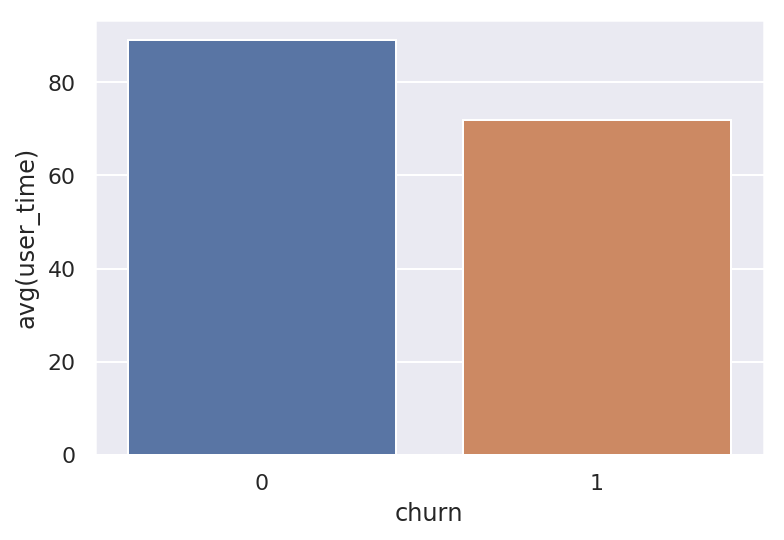

In [14]:
### registration time
user_use_time = user_log_clean.groupby('userId').agg(((F.max(user_log_clean.ts)-F.max(user_log_clean.registration))/(1000*60*60*24))\
                                                     .alias('user_time')).sort('userId')
user_log_label = user_log_label.join(user_use_time, user_log_label.userId==user_use_time.userId).drop(user_use_time.userId)
registration_df = user_log_label.groupby('churn').agg(avg(user_log_label.user_time)).toPandas()
sns.barplot(x='churn',y='avg(user_time)',data=registration_df);

In [56]:
#location
user_log_clean.select('location').drop_duplicates().take(10)

[Row(location='Atlantic City-Hammonton, NJ'),
 Row(location='Gainesville, FL'),
 Row(location='Richmond, VA'),
 Row(location='Tucson, AZ'),
 Row(location='Oskaloosa, IA'),
 Row(location='San Diego-Carlsbad, CA'),
 Row(location='Deltona-Daytona Beach-Ormond Beach, FL'),
 Row(location='Cleveland-Elyria, OH'),
 Row(location='Medford, OR'),
 Row(location='Kingsport-Bristol-Bristol, TN-VA')]

In [15]:
# check all the page types
user_log_clean.select('page').drop_duplicates().sort('page').collect()

[Row(page='About'),
 Row(page='Add Friend'),
 Row(page='Add to Playlist'),
 Row(page='Cancel'),
 Row(page='Cancellation Confirmation'),
 Row(page='Downgrade'),
 Row(page='Error'),
 Row(page='Help'),
 Row(page='Home'),
 Row(page='Logout'),
 Row(page='NextSong'),
 Row(page='Roll Advert'),
 Row(page='Save Settings'),
 Row(page='Settings'),
 Row(page='Submit Downgrade'),
 Row(page='Submit Upgrade'),
 Row(page='Thumbs Down'),
 Row(page='Thumbs Up'),
 Row(page='Upgrade')]

Text(0.5, 0, 'Hour')

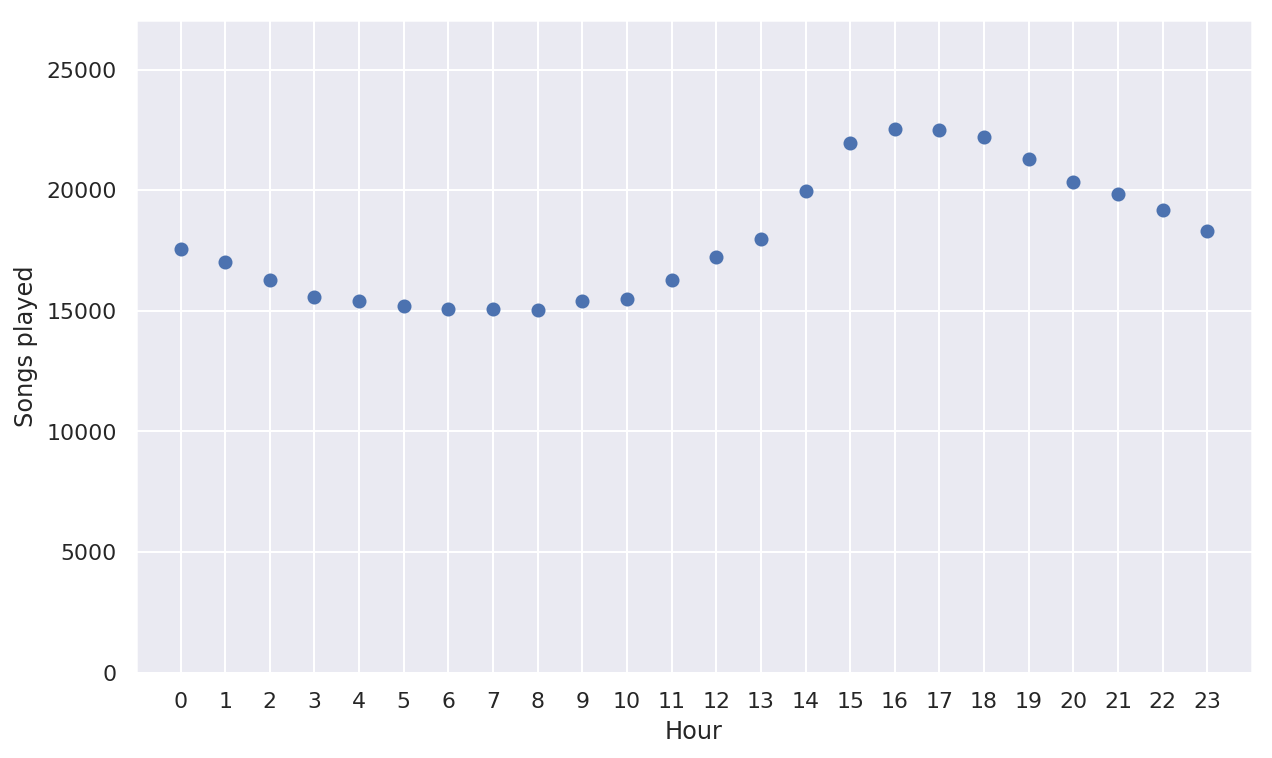

In [24]:
# number of songs are played for each hour using page=='NextSong'
song_in_hour = user_log_clean.select('hour').where(user_log_clean['page']=='NextSong').groupby('hour').count()\
              .orderBy(user_log_clean['hour'].cast('float')).toPandas()
plt.figure(figsize=(10,6))
plt.scatter(song_in_hour['hour'], song_in_hour['count'])
plt.xlim(-1,24)
plt.ylim(0, 1.2*max(song_in_hour['count']))
plt.ylabel('Songs played')
plt.xlabel('Hour')

Text(0.5, 0, 'Hour')

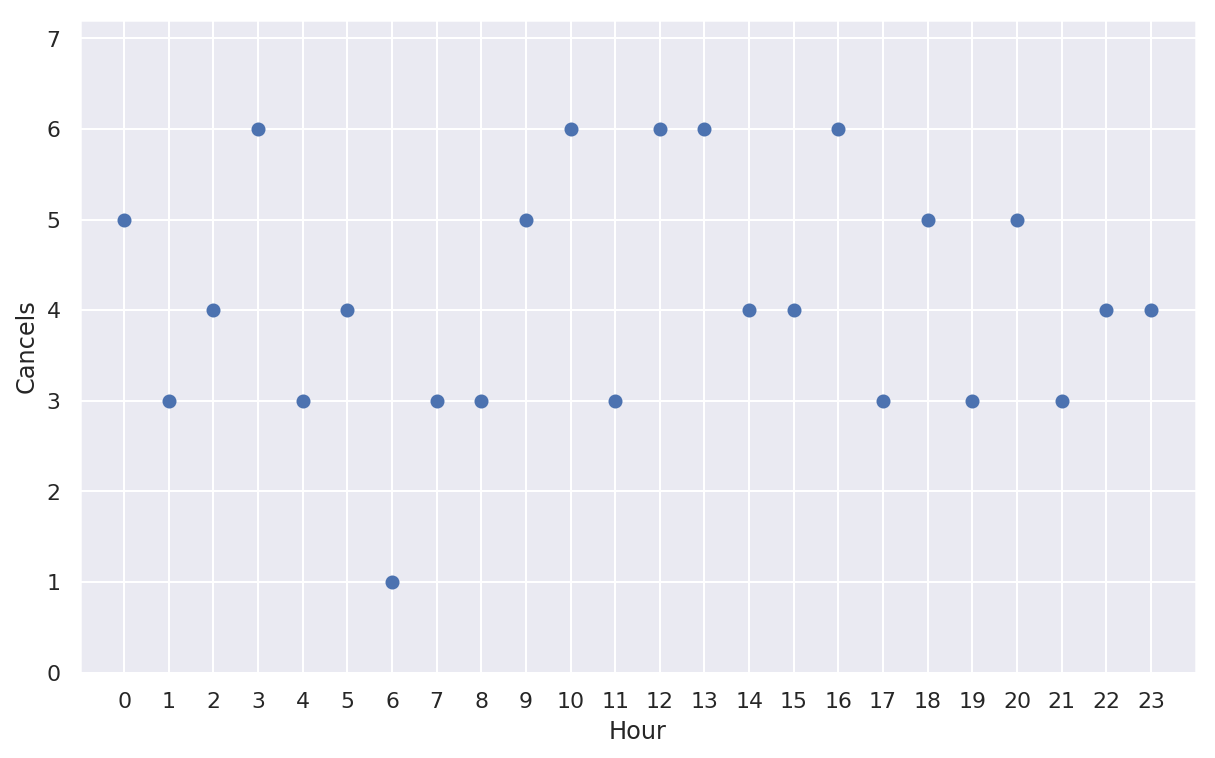

In [25]:
cancel_in_hour = user_log_clean.select('hour').where(user_log_clean['page']=='Cancellation Confirmation').groupby('hour').count()\
              .orderBy(user_log_clean['hour'].cast('float')).toPandas()
plt.figure(figsize=(10,6))
plt.scatter(cancel_in_hour['hour'], cancel_in_hour['count'])
plt.xlim(-1,24)
plt.ylim(0, 1.2*max(cancel_in_hour['count']))
plt.ylabel('Cancels')
plt.xlabel('Hour')

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

In [15]:
user_log_label.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- location: string (nullable = true)
 |-- level: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- page: string (nullable = true)
 |-- phase: long (nullable = true)
 |-- churn: integer (nullable = true)



## feature 1: gender

In [14]:
gender_feature = user_log_label.select('userId','gender').sort('userId')
assert gender_feature.count()==448
gender_feature = gender_feature.replace(['M','F'], ['0','1'], 'gender')
gender_feature = gender_feature.select('userId',gender_feature.gender.cast('int')).sort('userId')
gender_feature.show(5)

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
+------+------+
only showing top 5 rows



## feature 2: level

In [15]:
level_feature = user_log_label.select('userId','level').sort('userId')
assert level_feature.count()==448
level_feature = level_feature.replace(['paid','free'], ['0','1'], 'level')
level_feature = level_feature.select('userId', level_feature.level.cast('int')).sort('userId')
level_feature.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



## feature 3: phase (ever upgraded? downgraded? upgraded+downgraded?)

In [16]:
grade_feature = user_log_label.select('userId','phase').sort('userId')
assert grade_feature.count()==448
# define functions
downgraded_mark = udf(lambda x: 1 if (x==1 or x>=3) else 0, IntegerType()) # 1是只downgrade，大于等于3是既downgrade又upgrade
upgraded_mark = udf(lambda x: 1 if (x==2 or x>=3) else 0, IntegerType())
grade_feature = grade_feature.withColumn('downgraded', downgraded_mark('phase'))
grade_feature = grade_feature.withColumn('upgraded', upgraded_mark('phase'))
grade_feature = grade_feature.drop('phase')
grade_feature.show(5)

+------+----------+--------+
|userId|downgraded|upgraded|
+------+----------+--------+
|    10|         0|       0|
|   100|         0|       1|
|100001|         0|       0|
|100002|         1|       1|
|100003|         0|       1|
+------+----------+--------+
only showing top 5 rows



## feature 4: number of songs listened

In [17]:
num_songs_feature = user_log_clean.select('userId').filter(user_log_clean.page=='NextSong')\
                                  .groupby('userId').count().withColumnRenamed('count', 'num_songs_listened')
assert num_songs_feature.count()==448
num_songs_feature.show(5)

+------+------------------+
|userId|num_songs_listened|
+------+------------------+
|   296|               112|
|100010|                96|
|200002|               310|
|   125|                62|
|    51|               266|
+------+------------------+
only showing top 5 rows



## feature 5: number of songs per session

In [18]:
num_songs_session = user_log_clean.filter(user_log_clean.page=='NextSong').groupby('userId','sessionID').count()
num_songs_per_session_feature = num_songs_session.groupby('userId')\
          .agg(avg(num_songs_session['count']).alias('num_songs_listened_per_session')).sort('userId')
num_songs_per_session_feature = num_songs_per_session_feature\
           .select('userId',F.floor(num_songs_per_session_feature.num_songs_listened_per_session))\
           .withColumnRenamed('FLOOR(num_songs_listened_per_session)','num_songs_listened_per_session')
assert num_songs_per_session_feature.count()==448
num_songs_per_session_feature.show(5)

+------+------------------------------+
|userId|num_songs_listened_per_session|
+------+------------------------------+
|    10|                           360|
|   100|                            86|
|100001|                            32|
|100002|                            34|
|100003|                            82|
+------+------------------------------+
only showing top 5 rows



## feature 6: thumbs down, up

In [19]:
user_thumbs_down = user_log_clean.select('userId').where(user_log_clean.page=='Thumbs Down')\
                                 .groupby('userId').count().withColumnRenamed('count', 'num_thumbs_down').withColumnRenamed('userId','userId1')
user_thumbs_up = user_log_clean.select('userId').where(user_log_clean.page=='Thumbs Up')\
                                 .groupby('userId').count().withColumnRenamed('count', 'num_thumbs_up').withColumnRenamed('userId','userId2')
temp_view = user_log_clean.select('userId').drop_duplicates().sort('userId')
thumbs_feature = temp_view.join(user_thumbs_down, temp_view.userId==user_thumbs_down.userId1,'left_outer')\
                          .drop('userId1').fillna(0, subset=['num_thumbs_down']).sort('userId')
thumbs_feature = thumbs_feature.join(user_thumbs_up, thumbs_feature.userId==user_thumbs_up.userId2,'left_outer')\
                          .drop('userId2').fillna(0, subset=['num_thumbs_up']).sort('userId')
assert thumbs_feature.count()==448
thumbs_feature.show(5)

+------+---------------+-------+-------------+
|userId|num_thumbs_down|userId2|num_thumbs_up|
+------+---------------+-------+-------------+
|    10|              1|     10|           17|
|   100|             37|    100|          143|
|100001|              1| 100001|            5|
|100002|              2| 100002|            8|
|100003|             10| 100003|           16|
+------+---------------+-------+-------------+
only showing top 5 rows



## feature 7: user use days since registration

In [20]:
use_duration_feature = user_log_clean.groupby('userId')\
                    .agg(((F.max(user_log_clean.ts)-F.max(user_log_clean.registration))/(1000*60*60*24))
                         .alias('total_use_days'))
use_duration_feature = use_duration_feature.select('userId',F.floor(use_duration_feature.total_use_days))\
                       .sort('userId').withColumnRenamed('FLOOR(total_use_days)', 'total_use_days')
assert use_duration_feature.count()==448
use_duration_feature.show(5)

+------+--------------+
|userId|total_use_days|
+------+--------------+
|    10|            10|
|   100|            65|
|100001|            44|
|100002|           129|
|100003|            50|
+------+--------------+
only showing top 5 rows



## feature 8: session times, avg session time, max session time, min session time

In [21]:
sessionTime = user_log_clean.groupby('userId','sessionID')\
                            .agg(((F.max(user_log_clean.ts)-F.min(user_log_clean.ts))/(1000*60))\
                                 .alias('sessionTime')).sort('userId')
session_time_feature = sessionTime.groupby('userId').agg((F.avg(sessionTime['sessionTime'])).alias('AvgSessionTIme'),
                                                          F.max(sessionTime['sessionTime']).alias('MaxSessionTime'),
                                                          F.min(sessionTime['sessionTime']).alias('MinSessionTime'))\
                                   .sort('userId')
assert session_time_feature.count()==448
session_time_feature.show(5)

+------+------------------+------------------+--------------------+
|userId|    AvgSessionTIme|    MaxSessionTime|      MinSessionTime|
+------+------------------+------------------+--------------------+
|    10|            1502.4|            1502.4|              1502.4|
|   100| 350.4777777777777|1645.2333333333333|0.016666666666666666|
|100001|137.66111111111113|202.13333333333333|   42.13333333333333|
|100002|          150.2625|333.43333333333334|   52.63333333333333|
|100003|296.92777777777775|1277.2333333333333|                 0.0|
+------+------------------+------------------+--------------------+
only showing top 5 rows



## feature 9: use frequency of each page

In [22]:
# page list
page_lst = user_log_clean.select('page').drop_duplicates().toPandas()['page'].tolist()
page_freq_feature = user_log_clean.groupby('userId').count().withColumnRenamed('count', 'total_pages')
for page in page_lst:
    temp_view = user_log_clean.filter(user_log_clean.page==page).groupby('userId').count()\
                    .withColumnRenamed('count', page).withColumnRenamed('userId','userIdTemp')
    #assert temp_view.count()==total_pages_cnt.count()
    page_freq_feature = page_freq_feature.join(temp_view, 
                                             page_freq_feature.userId==temp_view.userIdTemp, 'left_outer')\
                        .drop('userIdTemp').fillna(0, subset=page).sort('userId')
    page_freq_feature = page_freq_feature.withColumn(page.replace(' ','')+'_freq',
                                             page_freq_feature[page]/page_freq_feature['total_pages'])\
                        .drop(page).sort('userId')
    
page_freq_feature = page_freq_feature.drop('total_pages').sort('userId')

assert page_freq_feature.count()==448

page_freq_feature.show(5)
# all the pages

# every page
#user_log_clean.groupby('userId','page').count().sort('userId').show()

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|userId|         Cancel_freq|SubmitDowngrade_freq|     ThumbsDown_freq|           Home_freq|      Downgrade_freq|     RollAdvert_freq|         Logout_freq|   SaveSettings_freq|CancellationConfirmation_freq|          About_freq|       Settings_freq|  AddtoPlaylist_freq|      AddFriend_freq|     NextSong_freq|       ThumbsUp_freq|           Help_freq|        Upgrade_freq|          Error_freq|  SubmitUpgrade_freq|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------

In [23]:
page_freq_feature.printSchema()

root
 |-- userId: string (nullable = true)
 |-- Cancel_freq: double (nullable = true)
 |-- SubmitDowngrade_freq: double (nullable = true)
 |-- ThumbsDown_freq: double (nullable = true)
 |-- Home_freq: double (nullable = true)
 |-- Downgrade_freq: double (nullable = true)
 |-- RollAdvert_freq: double (nullable = true)
 |-- Logout_freq: double (nullable = true)
 |-- SaveSettings_freq: double (nullable = true)
 |-- CancellationConfirmation_freq: double (nullable = true)
 |-- About_freq: double (nullable = true)
 |-- Settings_freq: double (nullable = true)
 |-- AddtoPlaylist_freq: double (nullable = true)
 |-- AddFriend_freq: double (nullable = true)
 |-- NextSong_freq: double (nullable = true)
 |-- ThumbsUp_freq: double (nullable = true)
 |-- Help_freq: double (nullable = true)
 |-- Upgrade_freq: double (nullable = true)
 |-- Error_freq: double (nullable = true)
 |-- SubmitUpgrade_freq: double (nullable = true)



## feature 10: different singers

In [24]:
num_singers_feature = user_log_clean.filter(user_log_clean.page=='NextSong').select('userId','artist')\
                                    .drop_duplicates().groupby('userId')\
                                    .count().withColumnRenamed('count','artists_listened').sort('userId')
assert num_singers_feature.count()==448
num_singers_feature.show(5)

+------+----------------+
|userId|artists_listened|
+------+----------------+
|    10|             306|
|   100|            1963|
|100001|              93|
|100002|             128|
|100003|             545|
+------+----------------+
only showing top 5 rows



In [34]:
### Combine all the features
features = [gender_feature, level_feature, grade_feature, num_songs_feature,
            num_songs_per_session_feature, thumbs_feature, use_duration_feature,
            session_time_feature, page_freq_feature, num_singers_feature]
user_log_final = user_log_clean.select('userId').drop_duplicates().sort('userId')
for feature_view in features:
    #assert user_log_final.count()==feature_view.count(), print(feature_view.printSchema())
    feature_view = feature_view.withColumnRenamed('userId', 'userIdTemp')
    user_log_final = user_log_final.join(feature_view, user_log_final.userId==feature_view.userIdTemp)\
                                   .drop('userIdTemp').sort('userId')
# label
label_churn = user_log_label.select('userId','churn').sort('userId').withColumnRenamed('userId', 'userIdTemp')
#assert label_churn.count()==448
user_log_data = user_log_final.join(label_churn, user_log_final.userId==label_churn.userIdTemp).drop('userIdTemp').sort('userId')
#assert user_log_data.count()==448
#out_path = 'user_log_data.csv'
#user_log_data.write.save(out_path, format='csv', header=True)

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

将选用以下三个分类模型训练数据
- Logistic Classifier
- Decision Tree Classifier
- GBT Classifier

In [78]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import ChiSqSelector

## Build Pipelines

In [213]:
class SparkPipeline:
    def __init__(self, df):
        self.data = self.to_features(df)
        
    def to_numeric(self, df):
        feature_lst = df.columns[1:]
        for feature in feature_lst:
            df = df.withColumn(feature+'_num', df[feature].cast('float'))
            df = df.drop(feature)
        df = df.fillna(0.0)
        
        return df
    
    def to_features(self, df):
        """
        numerate features;
        assemble features;
        standardize features;
        return df with features and labels
        """
        df = self.to_numeric(df)
        # assemble the features
        vecAssembler = VectorAssembler(inputCols=df.columns[1:-1], outputCol='num_features')
        user_for_model = vecAssembler.transform(df)
        # standardScale
        standardScaler = StandardScaler(inputCol='num_features', outputCol='features')
        standardModel = standardScaler.fit(user_for_model)
        user_for_model = standardModel.transform(user_for_model)
        # combine feature and label
        user_for_model = user_for_model.select(user_for_model.features, user_for_model.churn_num.alias('label'))
        
        return user_for_model
    
    def train_test_split(self):
        # stratify the label, evenly separating churn (using sampleBy func)
        train = self.data.sampleBy('label', fractions={0:0.9, 1:0.5}, seed=100)
        test = self.data.subtract(train)
        
        return train, test
    
    # compute f1 score
    def f1_score(self, results):

        evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
        
        f1 = evaluator.evaluate(results, {evaluator.metricName: 'f1'})
        
        return f1
    
    # logistic classifier
    def logistic_cls(self, train, test):
        lr = LogisticRegression()
    
        # set the number of iterations as default 100
        # grid tune the regulation parameters
        paramGrid = ParamGridBuilder()\
                    .addGrid(lr.regParam, [0.0, 0.05, 0.1]).build()
        
        crossval = CrossValidator(estimator=lr,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=MulticlassClassificationEvaluator())
        
        model = crossval.fit(train)
        
        print('Metrics: ',model.avgMetrics)
        #print(f'The best model for Logistic Regression is {model.bestModel}')
        
        results = model.transform(test)
        
        f1 = self.f1_score(results)
        
        print(f'F1 Score for Logistic Regression Model is:{f1}')
        
        return model
    
    # Random Forest
    def rf_cls(self, train, test):
        rf = RandomForestClassifier()
        
        paramGrid = ParamGridBuilder()\
                    .addGrid(rf.numTrees, [15,20,25])\
                    .addGrid(rf.impurity, ['entropy','gini']).build()
        
        crossval = CrossValidator(estimator=dt,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=MulticlassClassificationEvaluator())
        
        model = crossval.fit(train)
        
        print(f'Metrics: {model.avgMetrics}',)
        #print(f'The best model for Decision Tree is {model.bestModel}')
        
        results = model.transform(test)
        # compute f1 score
        f1 = self.f1_score(results)
        
        print(f'F1 Score for Random Forest is: {f1}')
        
        return model

## Train the data
由于最终的训练数据较少，而上述得出的特征数量较多，会导致训练数量与特征数量不均衡的情况，`应该遵循奥卡姆剃刀原理`,需要讨论不同特征数情况下模型的表现情况

### Use All Features

In [214]:
user_log_data = spark.read.csv('user_log_data.csv',header=True)
print(f'The number of features is {len(user_log_data.columns[1:-1])}')
print(f'The number of data is {user_log_data.count()}')

The number of features is 33
The number of data is 448


In [216]:
pipelines = SparkPipeline(user_log_data)
user_train, user_test = pipelines.train_test_split()
# logistic classifier
lr_model = pipelines.logistic_cls(user_train, user_test)
print('\n')
# random forest
rf_model = pipelines.rf_cls(user_train, user_test)

Metrics:  [0.9487492484658558, 0.833097807801227, 0.8220522046542502]
F1 Score for Logistic Regression Model is:0.8732554365465757


Metrics: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 Score for Random Forest is: 0.9747242721926267


`The Metric scores for DecisionTree and GBT model are 1.0, which is unlikely. Too many features`

### Use part of features -- remove all the freq features

In [217]:
user_log_data = spark.read.csv('user_log_data.csv',header=True)
user_log_data.columns

['userId',
 'gender',
 'level',
 'downgraded',
 'upgraded',
 'num_songs_listened',
 'num_songs_listened_per_session',
 'num_thumbs_down',
 'userId2',
 'num_thumbs_up',
 'total_use_days',
 'AvgSessionTIme',
 'MaxSessionTime',
 'MinSessionTime',
 'Cancel_freq',
 'SubmitDowngrade_freq',
 'ThumbsDown_freq',
 'Home_freq',
 'Downgrade_freq',
 'RollAdvert_freq',
 'Logout_freq',
 'SaveSettings_freq',
 'CancellationConfirmation_freq',
 'About_freq',
 'Settings_freq',
 'AddtoPlaylist_freq',
 'AddFriend_freq',
 'NextSong_freq',
 'ThumbsUp_freq',
 'Help_freq',
 'Upgrade_freq',
 'Error_freq',
 'SubmitUpgrade_freq',
 'artists_listened',
 'churn']

`Manually Selected Features`
- gender
- level
- downgraded
- upgraded
- num_songs_listened
- num_thumbs_up
- num_thumbs_down
- total_use_days
- AvgSessionTime
- artists_listened

In [218]:
#user_log_data = spark.read.csv('user_log_data.csv',header=True)
user_log_data = user_log_data.select('userId','gender','level','downgraded','upgraded','num_songs_listened',
                                     'num_thumbs_down','num_thumbs_up','total_use_days','AvgSessionTIme',
                                     'artists_listened','churn').sort('userId')
print(f'The number of features is {len(user_log_data.columns[1:-1])}')
print(f'The number of data is {user_log_data.count()}')

The number of features is 10
The number of data is 448


In [219]:
pipelines = SparkPipeline(user_log_data)
user_train, user_test = pipelines.train_test_split()
# logistic classifier
lr_model = pipelines.logistic_cls(user_train, user_test)
print('\n')
rf_model = pipelines.rf_cls(user_train, user_test)

Metrics:  [0.8397464343964877, 0.8247077049894078, 0.8247077049894078]
F1 Score for Logistic Regression Model is:0.2702818584923848


Metrics: [0.8506968164569575, 0.8506968164569575, 0.8506968164569575, 0.8506968164569575, 0.8506968164569575, 0.8506968164569575]
F1 Score for Random Forest is: 0.45623107542612185




`手动选择的十个特征最后得到的f1 score都不高，以下采用解决分类问题时的卡方检验特征选择`

### Using Chi-Square Feature Selection Method

In [153]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2

In [220]:
for num_feats in range(7,11):
    user_log_data = spark.read.csv('user_log_data.csv',header=True)
    
    # turn to pandas dataframe
    user_df = user_log_data.toPandas()
    user_df = user_df.drop(['userId2'], axis=1)
    user_df = user_df.iloc[:,1:].astype('float')
    
    # use chi-square to select features
    x = abs(user_df.iloc[:,0:-1])
    y = user_df.iloc[:,-1]
    bestfeatures = SelectKBest(score_func=chi2, k=num_feats)
    fit = bestfeatures.fit(x,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ['Specs', 'Score']
    select_feats = featureScores.nlargest(num_feats, 'Score')['Specs'].tolist()
    print(select_feats)
    
    user_log_data = user_log_data.select(['userId']+select_feats+['churn'])
    print(f'The number of features is {len(user_log_data.columns[1:-1])}')
    print(f'The number of data is {user_log_data.count()}')
    # train the model
    pipelines = SparkPipeline(user_log_data)
    user_train, user_test = pipelines.train_test_split()
    # logistic classifier
    lr_model = pipelines.logistic_cls(user_train, user_test)
    rf_model = pipelines.rf_cls(user_train, user_test)
    print('==============================')

['MinSessionTime', 'num_songs_listened', 'artists_listened', 'total_use_days', 'AvgSessionTIme', 'num_thumbs_up', 'num_songs_listened_per_session']
The number of features is 7
The number of data is 448
Metrics:  [0.789768330087671, 0.7924049755436997, 0.7924049755436997]
F1 Score for Logistic Regression Model is:0.3125492096178305
Metrics: [0.803857467834747, 0.803857467834747, 0.803857467834747, 0.803857467834747, 0.803857467834747, 0.803857467834747]
F1 Score for Random Forest is: 0.47974177830841047
['MinSessionTime', 'num_songs_listened', 'artists_listened', 'total_use_days', 'AvgSessionTIme', 'num_thumbs_up', 'num_songs_listened_per_session', 'MaxSessionTime']
The number of features is 8
The number of data is 448
Metrics:  [0.789768330087671, 0.7924049755436997, 0.7924049755436997]
F1 Score for Logistic Regression Model is:0.3125492096178305
Metrics: [0.8055804022487216, 0.8055804022487216, 0.8055804022487216, 0.8055804022487216, 0.8055804022487216, 0.8055804022487216]
F1 Score fo

- 分别选用7、8、9、10个特征数训练模型

- 当选择7、8、9个特征数时，f1 score没有变化

- 当特征数达到10个后，f1 score突然提升到接近100%

# Conclusion

- The best model is Random Forest model
- According to the Chi-Square feature selection method, Top features that affect the churn user is:
  Minimum Session Time, number of songs listened, number of different artists listened, total use days, number of thumbs-up times, numer of songs listened per session